# APS360 - Classifying Subreddits

Bassam Bibi<br>
Matthew Kwan

## Imports

In [24]:
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

## Load Data

In [56]:
#df = pd.read_csv('./data/updated_datav4.csv')
df = pd.read_csv('./data/updated_datav4.csv')
df.head()

,id,post,score,subreddit,title,url,subreddit_name
0,0,NaN,53782,0,"New ""Discovery Mode"" turns video game ""Assassi...",https://www.theverge.com/2018/2/20/17033024/as...,history
1,1,"Hi everyone and especially our students,\r\r\r...",38426,0,We are not here to help you with your End of T...,https://www.reddit.com/r/history/comments/8pw3...,history
2,2,NaN,35982,0,A 1776 excerpt from John Adam's diary where he...,https://founders.archives.gov/documents/Adams/...,history
3,3,NaN,34908,0,Famous Viking warrior burial revealed to be th...,http://www.news.com.au/technology/science/arch...,history
4,4,NaN,34197,0,"3,000-year-old underwater castle discovered in...",https://inhabitat.com/3000-year-old-underwater...,history


### Splitting Function for Punctuations

In [57]:
def split_post(post):
    # separate punctuations
    post = post.replace(".", " . ") \
                 .replace(",", " , ") \
                 .replace(";", " ; ") \
                 .replace("?", " ? ") 

    return post.split() # Returns each word as an index in a list


### Download GloVe Vectors

In [58]:
# Download pre-trained glove vectors

glove = torchtext.vocab.GloVe(name="6B", dim=50, max_vectors=20000) 

  5%|███▍                                                                    | 19415/400000 [00:00<00:09, 38720.02it/s]


### Function the Split Data into Train, Test and Valid

In [59]:
def get_post_words(glove_vector):
    train, valid, test = [], [], []
    for i, line in enumerate(df.post):
        
            
        # If there is no text content in the post, then use the title of the post instead

#         if line is np.nan:
#             post = df.title[i]
#         else:
#             post = line
        
        post = df.title[i]

        idxs = [glove_vector.stoi[w]        # lookup the index of word
                for w in split_post(post)
                if w in glove_vector.stoi] # keep words that has an embedding
        if not idxs: # ignore posts without any word with an embedding
            continue
        idxs = torch.tensor(idxs) # convert list to pytorch tensor
        label = torch.tensor(df.subreddit[i]).long() #IMPORTANT, need to convert this to numerical category
        if i % 5 < 3:
            train.append((idxs, label))
        elif i % 5 == 4:
            valid.append((idxs, label))
        else:
            test.append((idxs, label))
    return train, valid, test

train,valid,test = get_post_words(glove)

In [60]:
print("Train Length: {} Val Length: {} Test Length: {}".format(len(train),len(valid),len(test)))

Train Length: 7417 Val Length: 2478 Test Length: 2478


## Batching

In [36]:
import random

class PostBatcher:
    def __init__(self, posts, batch_size=32, drop_last=False):
        # store posts by length
        self.posts_by_length = {}
        for words, label in posts:
            # compute the length of the post
            wlen = words.shape[0]
            # put the posts in the correct key inside self.posts_by_length
            if wlen not in self.posts_by_length:
                self.posts_by_length[wlen] = []
            self.posts_by_length[wlen].append((words, label),)
         
        #  create a DataLoader for each set of posts of the same length
        self.loaders = {wlen : torch.utils.data.DataLoader(
                                    posts,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    drop_last=drop_last) # omit last batch if smaller than batch_size
            for wlen, posts in self.posts_by_length.items()}
        
    def __iter__(self): # called by Python to create an iterator
        # make an iterator for every post length
        iters = [iter(loader) for loader in self.loaders.values()]
        while iters:
            # pick an iterator (a length)
            im = random.choice(iters)
            try:
                yield next(im)
            except StopIteration:
                # no more elements in the iterator, remove it
                iters.remove(im)

With our batching function working, let's define our data loaders. Let's start with a batch-size of 16:

In [37]:
train_loader = PostBatcher(train,batch_size=128,drop_last=True)
valid_loader = PostBatcher(train,batch_size=128,drop_last=True)

In [38]:
for i, (posts, labels) in enumerate(train_loader):
    if i > 5: break
    print(posts.shape, labels.shape)

torch.Size([128, 4]) torch.Size([128])
torch.Size([128, 29]) torch.Size([128])
torch.Size([128, 25]) torch.Size([128])
torch.Size([128, 16]) torch.Size([128])
torch.Size([128, 4]) torch.Size([128])
torch.Size([128, 11]) torch.Size([128])


In [10]:
train_loader

## Preliminary Model

In [54]:
class RedditLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes=13):
        super(RedditLSTM, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=3)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state and cell state
        h0 = torch.zeros(3, x.size(0), self.hidden_size)
        c0 = torch.zeros(3, x.size(0), self.hidden_size)
        # Forward propagate the LSTM
        out, _ = self.rnn(x, (h0, c0))
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

## Training 

In [13]:
# Function to calculate the accuracy of the results. 
# Returns: # of Correct Predictions / Total # of Predictions

def get_accuracy(model, data_loader, find_loss=False):
  
    criterion = nn.CrossEntropyLoss()

    correct, total = 0, 0
    for posts, labels in data_loader:
        output = model(posts)
        if find_loss == True:
            loss = criterion(output,labels)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
   
    if find_loss == False:
        return correct / total
    else:
        return correct / total,loss

## Train Function for Adam Optimizer

In [14]:
def train_rnn_network(model, train, valid, num_epochs=200, learning_rate=1e-4):
    criterion = nn.CrossEntropyLoss() # Need Cross Entropy for Multi-Classification

    #optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)
    #optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc, val_losses = [], [], [], []
    loss = 0
    epochs = []
    for epoch in range(num_epochs):
        for posts, labels in train:
            optimizer.zero_grad()
            pred = model(posts)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        val_acc,val_loss = get_accuracy(model, valid_loader, find_loss=True)
        val_losses.append(val_loss)
        valid_acc.append(val_acc)
        if epoch%10 == 0:
            print("Epoch %d; Train Loss %f; Validation Loss %f; Train Acc %f; Val Acc %f" % (
                  epoch, loss, val_loss, train_acc[-1], valid_acc[-1]))
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.plot(val_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    
    return loss, val_loss, train_acc[-1], valid_acc[-1]

## Train Function for RMSProp

In [15]:
def train_rnn_network_rms(model, train, valid, num_epochs=200, learning_rate=0.01):
    criterion = nn.CrossEntropyLoss() # Need Cross Entropy for Multi-Classification

    #optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)
    optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)
    #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc, val_losses = [], [], [], []
    loss = 0
    epochs = []
    for epoch in range(num_epochs):
        for posts, labels in train:
            optimizer.zero_grad()
            pred = model(posts)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        val_acc,val_loss = get_accuracy(model, valid_loader, find_loss=True)
        val_losses.append(val_loss)
        valid_acc.append(val_acc)
        if epoch%10 == 0:
            print("Epoch %d; Train Loss %f; Validation Loss %f; Train Acc %f; Val Acc %f" % (
                  epoch, loss, val_loss, train_acc[-1], valid_acc[-1]))
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.plot(val_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    
    return loss, val_loss, train_acc[-1], valid_acc[-1]

## Train Function for AdaGrad

In [16]:
def train_rnn_network_ada(model, train, valid, num_epochs=200, learning_rate=0.01):
    criterion = nn.CrossEntropyLoss() # Need Cross Entropy for Multi-Classification

    optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)
    #optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)
    #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc, val_losses = [], [], [], []
    loss = 0
    epochs = []
    for epoch in range(num_epochs):
        for posts, labels in train:
            optimizer.zero_grad()
            pred = model(posts)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        val_acc,val_loss = get_accuracy(model, valid_loader, find_loss=True)
        val_losses.append(val_loss)
        valid_acc.append(val_acc)
        if epoch%10 == 0:
            print("Epoch %d; Train Loss %f; Validation Loss %f; Train Acc %f; Val Acc %f" % (
                  epoch, loss, val_loss, train_acc[-1], valid_acc[-1]))
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.plot(val_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    
    return loss, val_loss, train_acc[-1], valid_acc[-1]

In [ ]:
model = RedditLSTM(50,50)
train_rnn_network(model,train_loader,valid_loader)

In [ ]:
# Create Test Loader
test_loader = PostBatcher(test,batch_size=16,drop_last=True)

In [56]:
test_acc = get_accuracy(model,test_loader)
print("Our accuracy on our test set was: {}".format(test_acc))

Our accuracy on our test set was: 0.546875


## Tuning Hyperparameters
First, let's try increasing the batch size to 32:

Epoch 0; Train Loss 2.575501; Validation Loss 2.569559; Train Acc 0.156250; Val Acc 0.160417
Epoch 50; Train Loss 1.890330; Validation Loss 1.718818; Train Acc 0.325000; Val Acc 0.347917


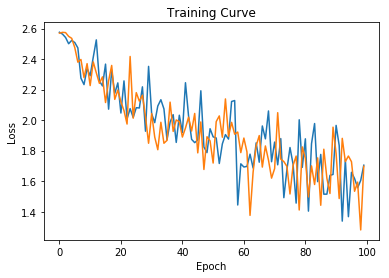

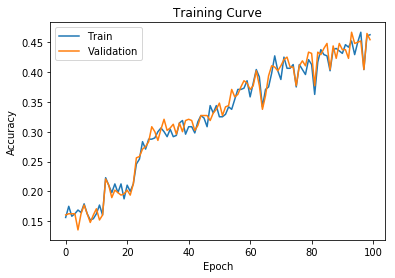

In [60]:
train_loader = PostBatcher(train,batch_size=32,drop_last=True)
valid_loader = PostBatcher(train,batch_size=32,drop_last=True)
model = RedditLSTM(50,50)
train_rnn_network(model,train_loader,valid_loader,num_epochs=100)

## Random Search
A function to help with hyperparameter tuning.

In [41]:
def RandomSearch(n_iters, batch_sizes, learning_rates, hidden_sizes, opt="adam"):
    """
    n_iters: number of iterations to perform.
    batch_sizes: list of batch sizes.
    learning_rates: list of learning rates.
    hidden_sizes: list of hidden unit sizes.
    """
    list_data = []
    
    for i in range(n_iters):
        bs = np.random.randint(0,high=len(batch_sizes))
        lr = np.random.randint(0,high=len(learning_rates))
        hs = np.random.randint(0,high=len(hidden_sizes))
        
        train_loader = PostBatcher(train,batch_size=batch_sizes[bs],drop_last=True)
        valid_loader = PostBatcher(valid,batch_size=batch_sizes[bs],drop_last=True)
        test_loader = PostBatcher(test,batch_size=batch_sizes[bs],drop_last=True)
        
        model = RedditLSTM(50,hidden_sizes[hs])
        
        print("Batch Size: {} Learning Rate: {} Hidden Size: {}".format(batch_sizes[bs],learning_rates[lr],
                                                                        hidden_sizes[hs]))
        
        if opt == "ada":
            print("ada")
            result = train_rnn_network_ada(model,train_loader,valid_loader, learning_rate=learning_rates[lr],
                                           num_epochs=100)
        elif opt == "RMS":
            print("RMS")
            result = train_rnn_network_rms(model,train_loader,valid_loader,learning_rate=learning_rates[lr],
                                           num_epochs=100)
        else:
            result = train_rnn_network(model,train_loader,valid_loader,learning_rate=learning_rates[lr],
                              num_epochs=100)
        
        test_result = get_accuracy(model,test_loader)
        print("Test accuracy: {}".format(test_result))
        list_data.append([i,batch_sizes[bs],learning_rates[lr],hidden_sizes[hs],result[0],result[1],
                          result[2],result[3],test_result])
    
    
    
    
    df = pd.DataFrame(list_data,columns=["Iter", "batch size", "learning rate", "hidden size", "train loss",
                                         "valid loss","train acc", "valid acc","test_acc"])
    
    file_name = "randomsearch_"+opt+".csv"
    
    df.to_csv(file_name,index = False)

### Random Search for Adam Optimizer

In [ ]:
batch_sizes = [8,16,32,64,128]
learning_rates = [1e-3,0.5e-3,1e-4,0.5e-4,1e-5,0.5e-5]
hidden_sizes = [32,64,128,256]

RandomSearch(60,batch_sizes,learning_rates,hidden_sizes)

### Random Search for RMSProp

In [36]:
batch_sizes = [8,16,32,64,128]
learning_rates = [0.01,0.005,0.001]
hidden_sizes = [32,64,128,256]

RandomSearch(6,batch_sizes,learning_rates,hidden_sizes,opt="RMS")

Batch Size: 16 Learning Rate: 0.001 Hidden Size: 256
RMS
0
Epoch 0; Train Loss 2.187973; Validation Loss 2.063670; Train Acc 0.311849; Val Acc 0.319661


KeyboardInterrupt: 

### Random Search for Adam

Batch Size: 128 Learning Rate: 0.005 Hidden Size: 256
Epoch 0; Train Loss 2.385680; Validation Loss 2.169358; Train Acc 0.217822; Val Acc 0.216518
Epoch 10; Train Loss 1.026474; Validation Loss 1.406706; Train Acc 0.648824; Val Acc 0.518415
Epoch 20; Train Loss 0.103504; Validation Loss 1.753283; Train Acc 0.906714; Val Acc 0.549107
Epoch 30; Train Loss 0.008666; Validation Loss 2.532454; Train Acc 0.933323; Val Acc 0.542969
Epoch 40; Train Loss 0.001147; Validation Loss 1.326214; Train Acc 0.939047; Val Acc 0.561384
Epoch 50; Train Loss 0.266070; Validation Loss 2.024387; Train Acc 0.875309; Val Acc 0.525112
Epoch 60; Train Loss 0.002299; Validation Loss 2.030166; Train Acc 0.941522; Val Acc 0.547433
Epoch 70; Train Loss 0.000351; Validation Loss 2.515361; Train Acc 0.941832; Val Acc 0.558594
Epoch 80; Train Loss 0.000117; Validation Loss 1.133060; Train Acc 0.941677; Val Acc 0.561384
Epoch 90; Train Loss 0.000147; Validation Loss 3.833368; Train Acc 0.941368; Val Acc 0.556920


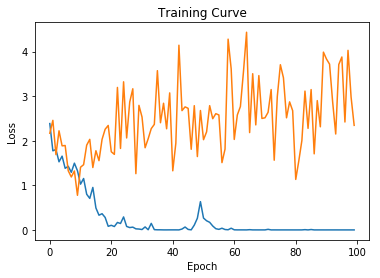

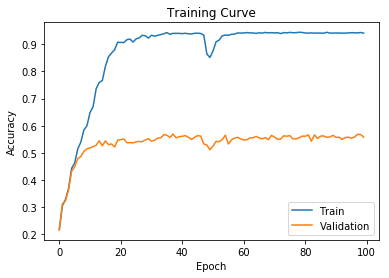

Test accuracy: 0.5533854166666666
Batch Size: 8 Learning Rate: 0.01 Hidden Size: 128
Epoch 0; Train Loss 2.647757; Validation Loss 2.442439; Train Acc 0.144802; Val Acc 0.132254
Epoch 10; Train Loss 1.224147; Validation Loss 1.515872; Train Acc 0.461943; Val Acc 0.439732
Epoch 20; Train Loss 1.166366; Validation Loss 1.946874; Train Acc 0.617574; Val Acc 0.479911
Epoch 30; Train Loss 1.371936; Validation Loss 3.035747; Train Acc 0.674041; Val Acc 0.502790
Epoch 40; Train Loss 0.711896; Validation Loss 1.580701; Train Acc 0.695699; Val Acc 0.496652
Epoch 50; Train Loss 1.744196; Validation Loss 1.224350; Train Acc 0.675588; Val Acc 0.511719
Epoch 60; Train Loss 0.890823; Validation Loss 0.851403; Train Acc 0.691213; Val Acc 0.524554
Epoch 70; Train Loss 1.158980; Validation Loss 1.469786; Train Acc 0.675278; Val Acc 0.491629
Epoch 80; Train Loss 1.009443; Validation Loss 1.143562; Train Acc 0.598391; Val Acc 0.482143
Epoch 90; Train Loss 0.938317; Validation Loss 1.653171; Train Acc 0.6

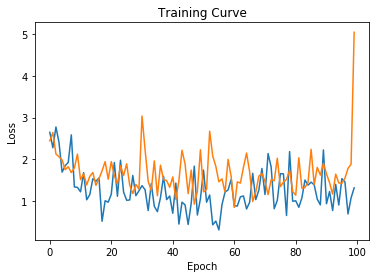

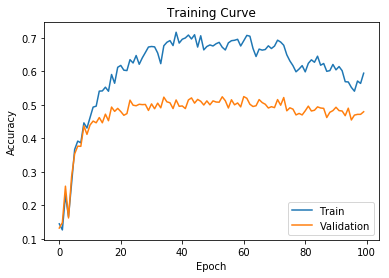

Test accuracy: 0.46096491228070174
Batch Size: 64 Learning Rate: 0.001 Hidden Size: 256
Epoch 0; Train Loss 1.829232; Validation Loss 2.123473; Train Acc 0.278929; Val Acc 0.277344
Epoch 10; Train Loss 1.025108; Validation Loss 1.233440; Train Acc 0.635520; Val Acc 0.540179
Epoch 20; Train Loss 0.261596; Validation Loss 1.578432; Train Acc 0.887067; Val Acc 0.551339
Epoch 30; Train Loss 0.023137; Validation Loss 1.658564; Train Acc 0.958385; Val Acc 0.552455
Epoch 40; Train Loss 0.002232; Validation Loss 3.211452; Train Acc 0.967976; Val Acc 0.568080
Epoch 50; Train Loss 0.030655; Validation Loss 2.072093; Train Acc 0.970916; Val Acc 0.557478
Epoch 60; Train Loss 0.007330; Validation Loss 4.207844; Train Acc 0.973855; Val Acc 0.546875
Epoch 70; Train Loss 0.003361; Validation Loss 2.881254; Train Acc 0.974010; Val Acc 0.551897
Epoch 80; Train Loss 0.001119; Validation Loss 3.894137; Train Acc 0.973700; Val Acc 0.548549
Epoch 90; Train Loss 0.000740; Validation Loss 2.864181; Train Acc 

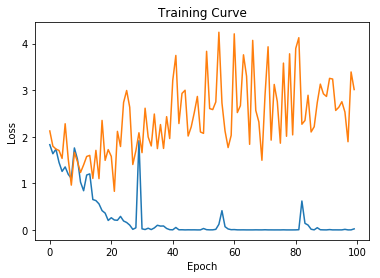

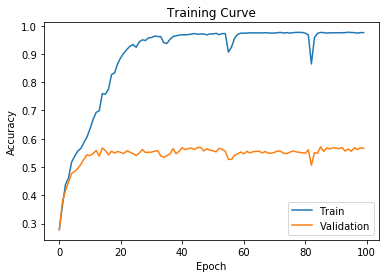

Test accuracy: 0.5441576086956522
Batch Size: 8 Learning Rate: 0.05 Hidden Size: 32
Epoch 0; Train Loss 2.426985; Validation Loss 2.455374; Train Acc 0.084004; Val Acc 0.083147
Epoch 10; Train Loss 2.086843; Validation Loss 2.412648; Train Acc 0.140625; Val Acc 0.147879
Epoch 20; Train Loss 2.113199; Validation Loss 2.215571; Train Acc 0.142481; Val Acc 0.146763
Epoch 30; Train Loss 2.428052; Validation Loss 2.160925; Train Acc 0.148515; Val Acc 0.155692
Epoch 40; Train Loss 2.075411; Validation Loss 2.133172; Train Acc 0.150526; Val Acc 0.155134
Epoch 50; Train Loss 2.197237; Validation Loss 2.556127; Train Acc 0.112778; Val Acc 0.121094
Epoch 60; Train Loss 2.659024; Validation Loss 2.432093; Train Acc 0.086170; Val Acc 0.084821
Epoch 70; Train Loss 3.174940; Validation Loss 2.139731; Train Acc 0.161355; Val Acc 0.168527
Epoch 80; Train Loss 2.206821; Validation Loss 2.368604; Train Acc 0.147123; Val Acc 0.150670
Epoch 90; Train Loss 1.997785; Validation Loss 2.573705; Train Acc 0.14

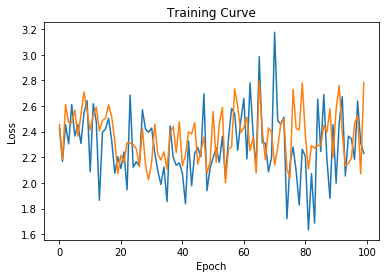

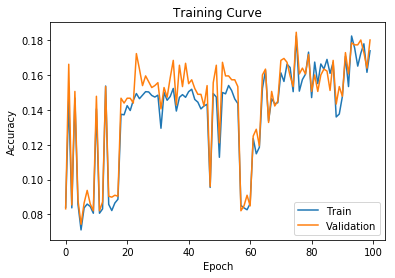

Test accuracy: 0.16228070175438597
Batch Size: 64 Learning Rate: 0.005 Hidden Size: 256
Epoch 0; Train Loss 1.691831; Validation Loss 1.850736; Train Acc 0.318998; Val Acc 0.322545
Epoch 10; Train Loss 0.430003; Validation Loss 1.124734; Train Acc 0.834623; Val Acc 0.558036
Epoch 20; Train Loss 0.094342; Validation Loss 2.370646; Train Acc 0.950495; Val Acc 0.532924
Epoch 30; Train Loss 0.066308; Validation Loss 2.582155; Train Acc 0.956219; Val Acc 0.543527
Epoch 40; Train Loss 0.008147; Validation Loss 2.674107; Train Acc 0.969988; Val Acc 0.544085
Epoch 50; Train Loss 0.000205; Validation Loss 3.363358; Train Acc 0.974474; Val Acc 0.554688
Epoch 60; Train Loss 0.000225; Validation Loss 2.878211; Train Acc 0.974629; Val Acc 0.547433
Epoch 70; Train Loss 0.000034; Validation Loss 2.277032; Train Acc 0.974938; Val Acc 0.550223
Epoch 80; Train Loss 0.000109; Validation Loss 3.428406; Train Acc 0.976485; Val Acc 0.544643
Epoch 90; Train Loss 0.000040; Validation Loss 2.936240; Train Acc 

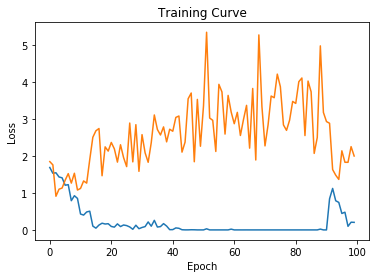

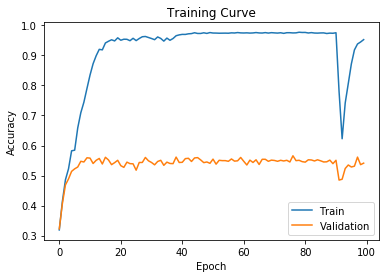

Test accuracy: 0.5597826086956522
Batch Size: 128 Learning Rate: 0.05 Hidden Size: 128
Epoch 0; Train Loss 2.495647; Validation Loss 2.421947; Train Acc 0.082147; Val Acc 0.086496
Epoch 10; Train Loss 2.576424; Validation Loss 2.390516; Train Acc 0.117574; Val Acc 0.121094
Epoch 20; Train Loss 2.150390; Validation Loss 2.264451; Train Acc 0.264387; Val Acc 0.284040
Epoch 30; Train Loss 1.843359; Validation Loss 1.946491; Train Acc 0.341429; Val Acc 0.333147
Epoch 40; Train Loss 1.834876; Validation Loss 2.093039; Train Acc 0.365099; Val Acc 0.358817
Epoch 50; Train Loss 1.458334; Validation Loss 1.658771; Train Acc 0.406095; Val Acc 0.373884
Epoch 60; Train Loss 1.484390; Validation Loss 2.081702; Train Acc 0.411200; Val Acc 0.368304
Epoch 70; Train Loss 1.682734; Validation Loss 2.314926; Train Acc 0.401454; Val Acc 0.362723
Epoch 80; Train Loss 2.170963; Validation Loss 1.826930; Train Acc 0.386912; Val Acc 0.368862
Epoch 90; Train Loss 1.618960; Validation Loss 2.596200; Train Acc 0

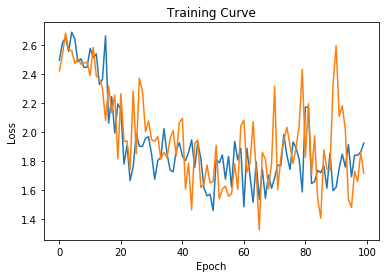

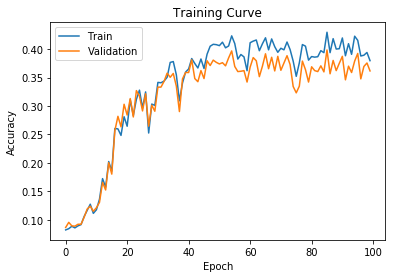

Test accuracy: 0.39453125


In [66]:
batch_sizes = [8,16,32,64,128]
learning_rates = [0.01,0.005,0.05,0.1,0.001]
hidden_sizes = [32,64,128,256]

RandomSearch(6,batch_sizes,learning_rates,hidden_sizes)

### Random Search with Adagrad Optimizer

Batch Size: 16 Learning Rate: 0.001 Hidden Size: 64
ada
0
Epoch 0; Train Loss 2.860583; Validation Loss 3.056973; Train Acc 0.055339; Val Acc 0.051758
10
20
30
40
50
Epoch 50; Train Loss 2.337004; Validation Loss 2.476743; Train Acc 0.221680; Val Acc 0.225586
60
70
80
90


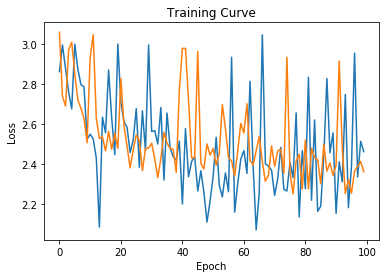

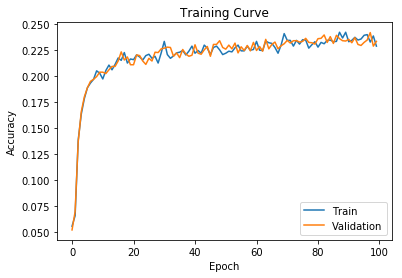

Test accuracy: 0.2587809917355372
Batch Size: 16 Learning Rate: 0.01 Hidden Size: 32
ada
0
Epoch 0; Train Loss 2.570073; Validation Loss 2.357411; Train Acc 0.202474; Val Acc 0.208008
10
20
30
40
50
Epoch 50; Train Loss 1.908245; Validation Loss 1.753107; Train Acc 0.385091; Val Acc 0.384766
60
70
80
90


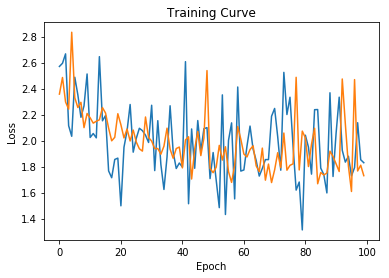

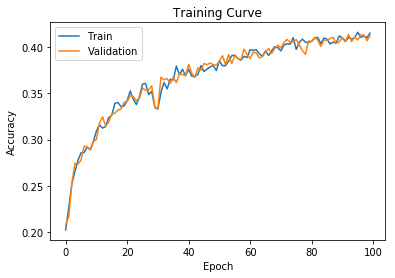

Test accuracy: 0.4106404958677686
Batch Size: 8 Learning Rate: 0.001 Hidden Size: 128
ada
0
Epoch 0; Train Loss 2.936294; Validation Loss 3.121912; Train Acc 0.111654; Val Acc 0.109701
10
20
30
40
50
Epoch 50; Train Loss 2.424985; Validation Loss 2.379277; Train Acc 0.278320; Val Acc 0.277344


KeyboardInterrupt: 

In [35]:
batch_sizes = [8,16,32,64,128]
learning_rates = [0.01,0.005,0.05,0.1,0.001]
hidden_sizes = [32,64,128,256]

RandomSearch(4,batch_sizes,learning_rates,hidden_sizes,opt="ada")

### Best Model

In [21]:
train_loader = PostBatcher(train,batch_size=32,drop_last=True)
valid_loader = PostBatcher(valid,batch_size=32,drop_last=True)
test_loader = PostBatcher(test,batch_size=32,drop_last=True)

model = RedditLSTM(100,256,num_classes=23)

train_rnn_network_rms(model,train_loader,valid_loader,num_epochs=100,learning_rate=0.005)

test_loader = PostBatcher(test,batch_size=32,drop_last=True)
test_result = get_accuracy(model,test_loader)
print("Test accuracy: {}".format(test_result))

Epoch 0; Train Loss 2.068000; Validation Loss 2.132568; Train Acc 0.131641; Val Acc 0.135417
Epoch 10; Train Loss 1.093850; Validation Loss 2.067837; Train Acc 0.539062; Val Acc 0.463542
Epoch 20; Train Loss 0.442021; Validation Loss 1.128934; Train Acc 0.910937; Val Acc 0.601562
Epoch 30; Train Loss 0.068111; Validation Loss 3.131502; Train Acc 0.973437; Val Acc 0.601562


KeyboardInterrupt: 

Epoch 0; Train Loss 1.850669; Validation Loss 1.999619; Train Acc 0.263150; Val Acc 0.276786
Epoch 10; Train Loss 0.814666; Validation Loss 0.902379; Train Acc 0.697246; Val Acc 0.539621
Epoch 20; Train Loss 0.550375; Validation Loss 1.888097; Train Acc 0.813892; Val Acc 0.513951
Epoch 30; Train Loss 0.390973; Validation Loss 1.944016; Train Acc 0.850402; Val Acc 0.501116
Epoch 40; Train Loss 0.382559; Validation Loss 2.759895; Train Acc 0.883973; Val Acc 0.518973
Epoch 50; Train Loss 0.488685; Validation Loss 1.743347; Train Acc 0.897123; Val Acc 0.515067
Epoch 60; Train Loss 0.273144; Validation Loss 2.632868; Train Acc 0.894802; Val Acc 0.500000
Epoch 70; Train Loss 0.211768; Validation Loss 1.013717; Train Acc 0.894338; Val Acc 0.511161
Epoch 80; Train Loss 0.495145; Validation Loss 2.737351; Train Acc 0.914295; Val Acc 0.506138
Epoch 90; Train Loss 0.185229; Validation Loss 2.317151; Train Acc 0.910118; Val Acc 0.512835


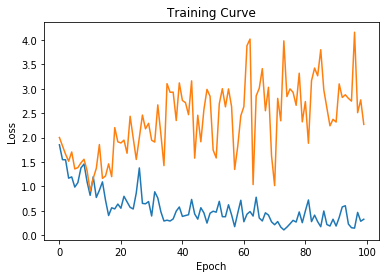

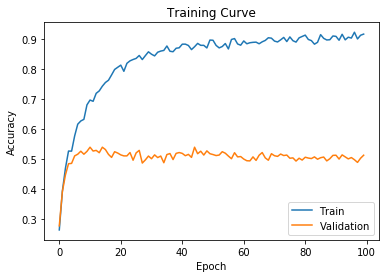

Test accuracy: 0.4872881355932203


In [64]:
train_loader = PostBatcher(train,batch_size=32,drop_last=True)
valid_loader = PostBatcher(valid,batch_size=32,drop_last=True)

model = RedditLSTM(50,25,num_classes=13)

train_rnn_network_rms(model,train_loader,valid_loader,num_epochs=100,learning_rate=0.01)

test_loader = PostBatcher(test,batch_size=32,drop_last=True)
test_result = get_accuracy(model,test_loader)
print("Test accuracy: {}".format(test_result))

Epoch 0; Train Loss 2.031351; Validation Loss 2.146837; Train Acc 0.313428; Val Acc 0.325893
Epoch 10; Train Loss 0.906271; Validation Loss 1.267634; Train Acc 0.773051; Val Acc 0.541295
Epoch 20; Train Loss 0.113390; Validation Loss 2.077263; Train Acc 0.936572; Val Acc 0.539621
Epoch 30; Train Loss 0.213509; Validation Loss 3.151721; Train Acc 0.949722; Val Acc 0.522879
Epoch 40; Train Loss 0.121429; Validation Loss 3.386603; Train Acc 0.964264; Val Acc 0.517299
Epoch 50; Train Loss 0.028313; Validation Loss 3.625997; Train Acc 0.974319; Val Acc 0.517299
Epoch 60; Train Loss 0.060772; Validation Loss 2.662345; Train Acc 0.969059; Val Acc 0.515067
Epoch 70; Train Loss 0.036926; Validation Loss 3.951318; Train Acc 0.976330; Val Acc 0.515625
Epoch 80; Train Loss 0.219036; Validation Loss 3.154349; Train Acc 0.974474; Val Acc 0.533482
Epoch 90; Train Loss 0.008563; Validation Loss 3.976000; Train Acc 0.979889; Val Acc 0.532366


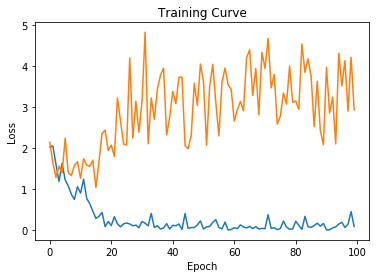

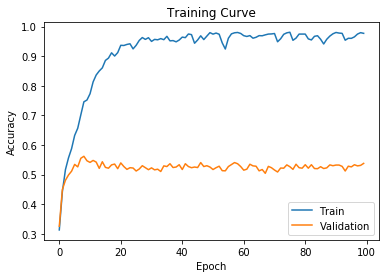

Test accuracy: 0.5153601694915254


In [65]:
train_loader = PostBatcher(train,batch_size=32,drop_last=True)
valid_loader = PostBatcher(valid,batch_size=32,drop_last=True)

model = RedditLSTM(50,50,num_classes=13)

train_rnn_network(model,train_loader,valid_loader,num_epochs=100,learning_rate=0.005)

test_loader = PostBatcher(test,batch_size=32,drop_last=True)
test_result = get_accuracy(model,test_loader)
print("Test accuracy: {}".format(test_result))